In [5]:
import time, joblib, os, math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from tensorflow import keras
from sklearn.metrics import mean_absolute_error, r2_score
from utils.dataset import load_dataset_v2, create_lstm_dataset
from tqdm.notebook import tqdm

In [6]:
file_name_list = os.listdir(os.path.join('data', 'ver_2'))
file_path_list = []

for file_name in file_name_list:
    file_path_list.append(os.path.join('data', 'ver_2', file_name))

start_time = time.strftime('%Y%m%d-%H%M%S', time.localtime(time.time()))

In [7]:
dataset= load_dataset_v2(file_path_list)

loading dataset...:   0%|          | 0/84 [00:00<?, ?it/s]

In [8]:
dataset.shape

(2315250, 18)

In [9]:
dataset = dataset[dataset['outlet_flowrate(lpm)'] > 1]
dataset = dataset[::10]
dataset.reset_index(drop=True, inplace=True)

In [10]:
dataset

time(s)  pressure_1(bar)  main_pressure(bar)  venturi_pressure_1(bar)  \
0         12.25            -0.05                3.01                     3.11   
1         12.35            -0.07                2.92                     3.04   
2         12.45            -0.06                3.08                     3.11   
3         12.55            -0.05                3.04                     3.06   
4         12.65            -0.08                2.83                     3.08   
...         ...              ...                 ...                      ...   
196555   233.62            -0.04               -0.01                     0.03   
196556   233.72            -0.03               -0.06                    -0.01   
196557   233.82            -0.05               -0.11                    -0.01   
196558   233.92            -0.04               -0.01                     0.03   
196559   234.02            -0.03               -0.07                    -0.01   

        venturi_pressure_2(bar)  venturi_pressure_3(bar)  \
0                          0.00                     0.02   
1                          0.02                     0.07   
2                          0.06                     0.12   
3                         -0.01                     0.00   
4                          0.01                     0.07   
...                         ...                      ...   
196555                     0.10                     0.07   
196556                     0.02                     0.04   
196557                     0.08                     0.09   
196558                     0.10                     0.07   
196559                     0.02                     0.05   

        venturi_pressure_4(bar)  venturi_pressure_5(bar)  pump_speed(rpm)  \
0                          0.13                     0.14           609.30   
1                          0.15                     0.23           605.70   
2                          0.14                     0.13           605.03   
3                          0.10                     0.17           608.29   
4                          0.12                     0.23           605.76   
...                         ...                      ...              ...   
196555                     0.03                    -0.05            -0.04   
196556                     0.03                    -0.01            -0.06   
196557                     0.08                    -0.00            -0.02   
196558                     0.03                    -0.03            -0.04   
196559                     0.05                    -0.00            -0.03   

        water_temp(c)  reserved  outlet_flowrate(lpm)  inlet_flowrate(lpm)  \
0               28.47       0.0                  1.63                -3.01   
1               28.46       0.0                  9.34                -2.94   
2               28.49       0.0                 18.83                -2.53   
3               28.50       0.0                 25.48                -2.46   
4               28.50       0.0                 33.20                -2.88   
...               ...       ...                   ...                  ...   
196555          32.27       0.0                 56.37                -2.48   
196556          32.27       0.0                 35.86                -2.11   
196557          32.27       0.0                 16.96                -2.18   
196558          32.27       0.0                 18.22                -2.58   
196559          32.28       0.0                 18.05                -2.70   

        test_case  test_case_iter  nozzle_len(mm)  nozzle_dia(mm)  \
0             1.0             1.0            12.0            12.0   
1             1.0             1.0            12.0            12.0   
2             1.0             1.0            12.0            12.0   
3             1.0             1.0            12.0            12.0   
4             1.0             1.0            12.0            12.0   
...           ...             ...     

In [11]:
#dataset['pressure_1(bar)'] = dataset['pressure_1(bar)'] *10


extra_column_name_list = ['pressure_1(bar)', 'main_pressure(bar)']
extra_feature = pd.DataFrame()

for col_name in extra_column_name_list:
    extra_feature['grad_'+col_name] = np.gradient(dataset[col_name].to_numpy())

dataset = pd.concat([dataset, extra_feature], axis=1)

In [12]:
dataset_value = dataset.drop(columns=['reserved', 'time(s)', 'test_case', 'test_case_iter'])
dataset_value = pd.concat([dataset_value, extra_feature], axis=1)

<AxesSubplot:>

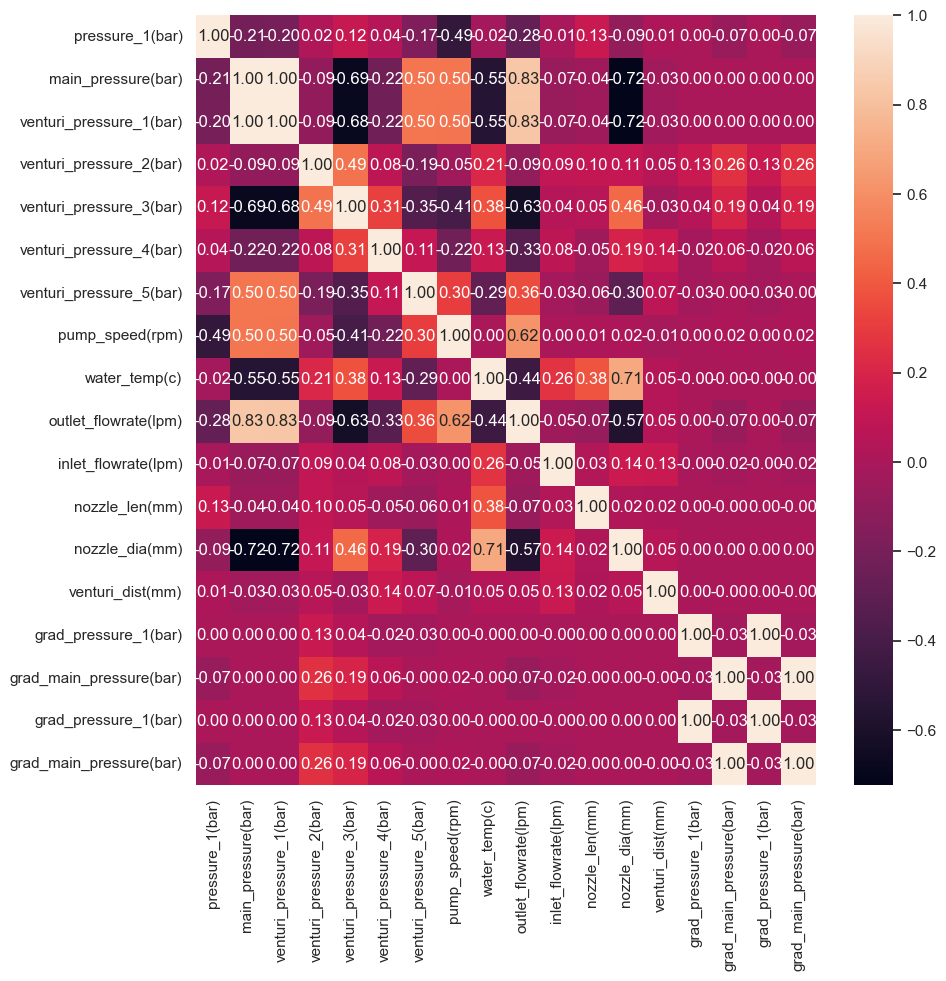

In [13]:
sns.set(font_scale=1.0)
plt.figure(figsize=(10, 10))
sns.heatmap(dataset_value.corr(), annot=True, fmt='.2f')

(-0.5, 0.5)

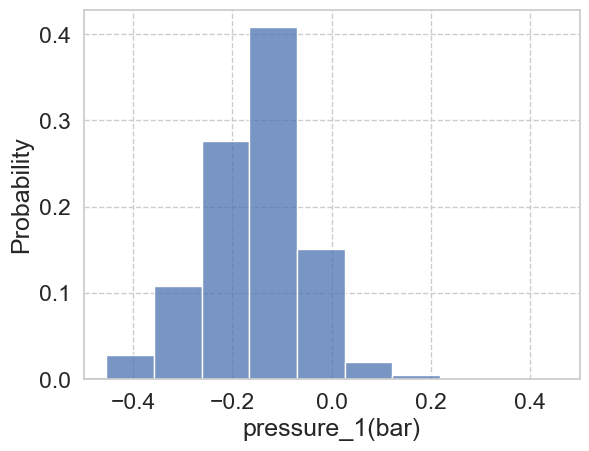

In [14]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
n_bin = math.ceil((dataset['pressure_1(bar)'].max()-dataset['pressure_1(bar)'].min())*10)
sns.histplot(dataset['pressure_1(bar)'], stat='probability', bins=n_bin)
#sns.histplot(val_data['pressure_1(bar)'], kde='True')
#plt.legend(title='Dataset Type', labels=['train', 'val'])
plt.xlim(-0.5, 0.5)
#prob = np.histogram(refined_dataset['main_pump_inlet_P(bar)'], bins=np.linspace(-3, -1, 31))
#entropy(pk=prob[0]/len(refined_dataset['main_pump_inlet_P(bar)']), base=2)

(-0.5, 0.5)

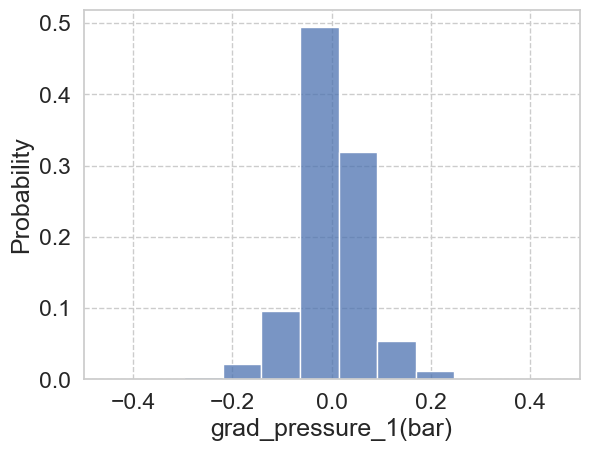

In [15]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
n_bin = math.ceil((dataset['grad_pressure_1(bar)'].max()-dataset['pressure_1(bar)'].min())*10)
sns.histplot(dataset['grad_pressure_1(bar)'], stat='probability', bins=n_bin)
#sns.histplot(val_data['pressure_1(bar)'], kde='True')
#plt.legend(title='Dataset Type', labels=['train', 'val'])
plt.xlim(-0.5, 0.5)
#prob = np.histogram(refined_dataset['main_pump_inlet_P(bar)'], bins=np.linspace(-3, -1, 31))
#entropy(pk=prob[0]/len(refined_dataset['main_pump_inlet_P(bar)']), base=2)

(0.0, 25.0)

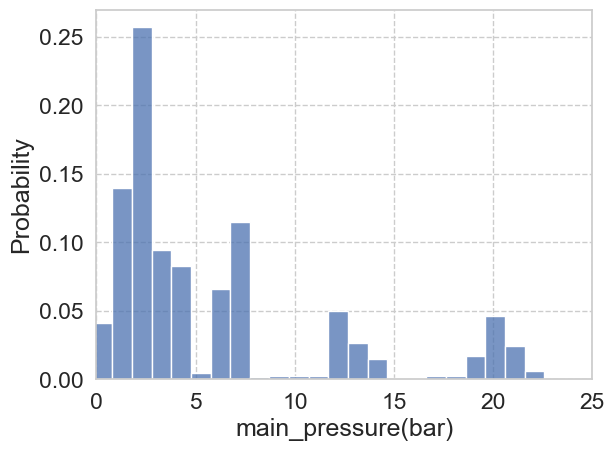

In [16]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
n_bin = math.ceil(dataset['main_pressure(bar)'].max()-dataset['main_pressure(bar)'].min())
sns.histplot(dataset['main_pressure(bar)'], stat='probability', bins=n_bin)
#sns.histplot(val_data['main_pressure(bar)'], kde='True')
#plt.legend(title='Dataset Type', labels=['train', 'val'])
plt.xlim(0, 25)
#prob = np.histogram(refined_dataset['main_pump_inlet_P(bar)'], bins=np.linspace(-3, -1, 31))
#entropy(pk=prob[0]/len(refined_dataset['main_pump_inlet_P(bar)']), base=2)

(-0.5, 0.5)

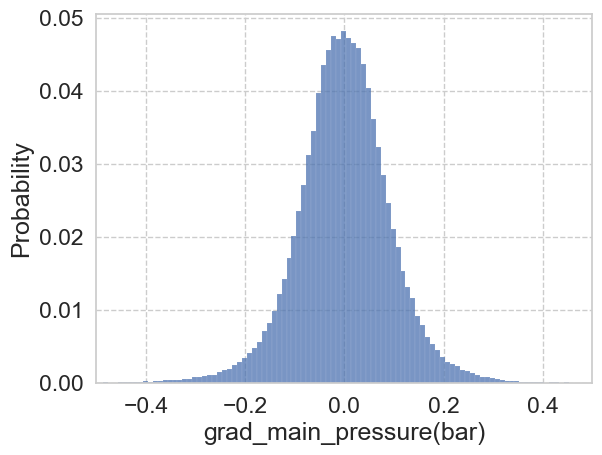

In [17]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
n_bin = math.ceil((dataset['grad_main_pressure(bar)'].max()-dataset['grad_main_pressure(bar)'].min())*100)
sns.histplot(dataset['grad_main_pressure(bar)'], stat='probability', common_norm=False, bins=n_bin)
#sns.histplot(val_data['pressure_1(bar)'], kde='True')
#plt.legend(title='Dataset Type', labels=['train', 'val'])
plt.xlim(-0.5, 0.5)
#prob = np.histogram(refined_dataset['main_pump_inlet_P(bar)'], bins=np.linspace(-3, -1, 31))
#entropy(pk=prob[0]/len(refined_dataset['main_pump_inlet_P(bar)']), base=2)

(28.0, 33.0)

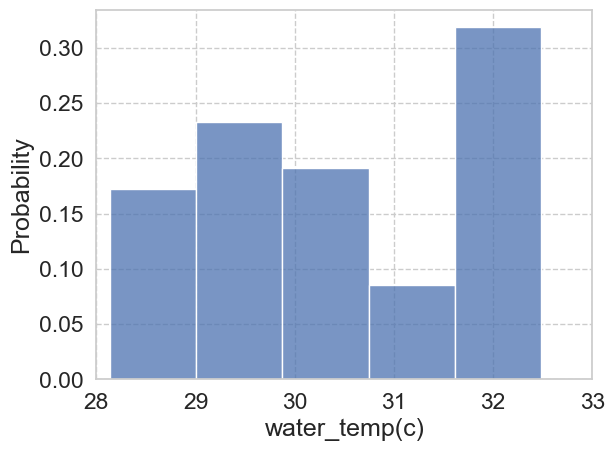

In [18]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
n_bin = math.ceil(dataset['water_temp(c)'].max()-dataset['water_temp(c)'].min())
sns.histplot(dataset['water_temp(c)'], stat='probability', bins=n_bin)
plt.xlim(28, 33)
#sns.histplot(val_data['water_temp(c)'], kde='True')
#plt.legend(title='Dataset Type', labels=['train', 'val'])
#prob = np.histogram(refined_dataset['main_pump_inlet_P(bar)'], bins=np.linspace(-3, -1, 31))
#entropy(pk=prob[0]/len(refined_dataset['main_pump_inlet_P(bar)']), base=2)

(0.0, 2500.0)

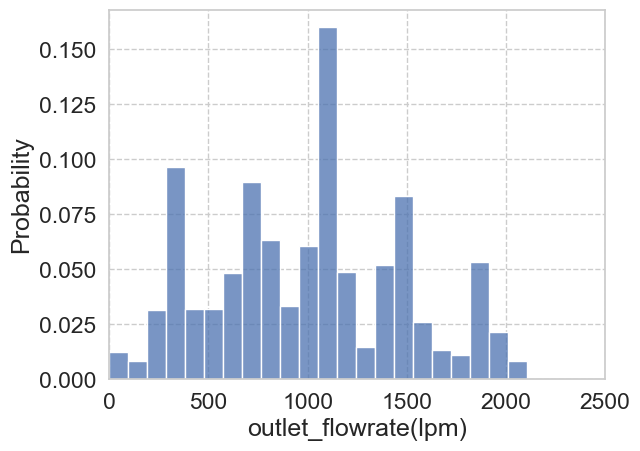

In [19]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
n_bin = math.ceil((dataset['outlet_flowrate(lpm)'].max()-dataset['outlet_flowrate(lpm)'].min())/100)
sns.histplot(dataset['outlet_flowrate(lpm)'], stat='probability', bins=n_bin)
plt.xlim(0, 2500)
#prob = np.histogram(refined_dataset['main_pump_inlet_P(bar)'], bins=np.linspace(-3, -1, 31))
#entropy(pk=prob[0]/len(refined_dataset['main_pump_inlet_P(bar)']), base=2)

Text(0, 0.5, 'Venturi Pump Outlet Flow-rate(LPM)')

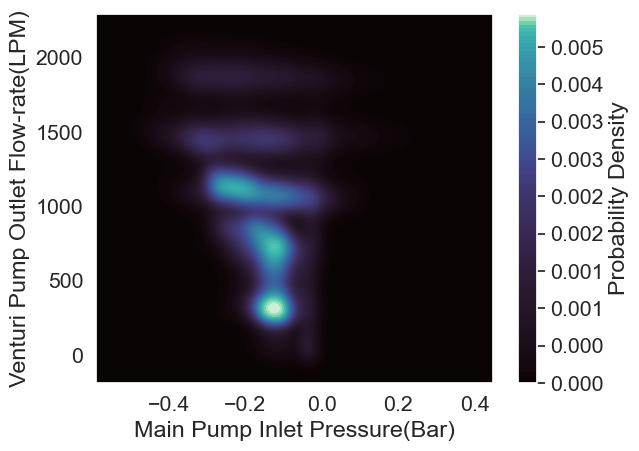

In [26]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')
sns.set(font_scale=1.4)
sns.kdeplot(data=dataset, x='pressure_1(bar)', y='outlet_flowrate(lpm)', thresh=0, levels=100, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.3f'})
plt.xlabel('Main Pump Inlet Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')

(0.0, 2500.0)

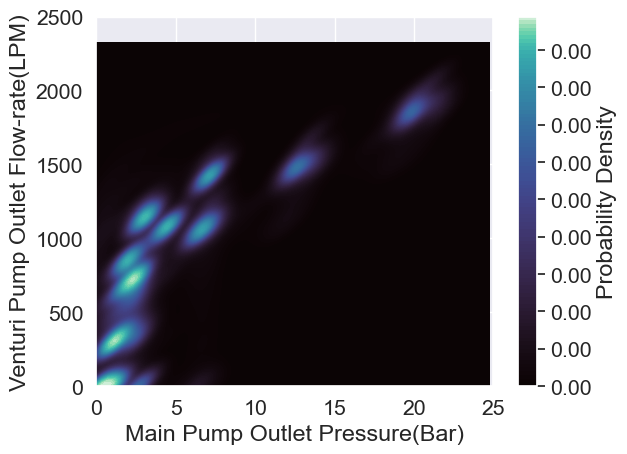

In [22]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')
sns.set(font_scale=1.4)
sns.kdeplot(data=dataset, x='main_pressure(bar)', y='outlet_flowrate(lpm)', thresh=0, levels=100, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.3f'})
plt.xlabel('Main Pump Outlet Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')

Text(0, 0.5, 'Venturi Pump Outlet Flow-rate(LPM)')

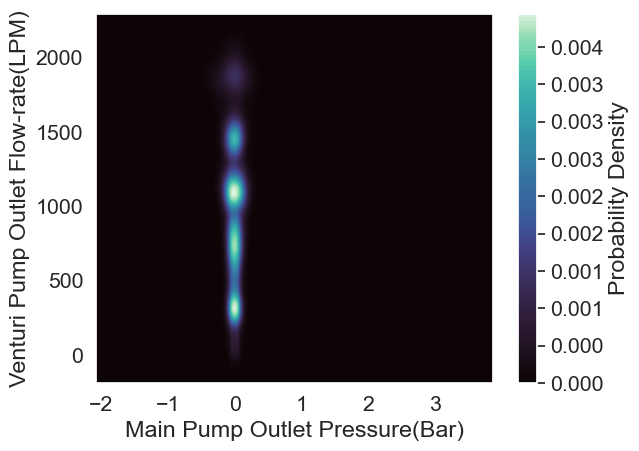

In [43]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')
sns.set(font_scale=1.4)
sns.kdeplot(data=dataset, x=np.gradient(dataset['main_pressure(bar)'].to_numpy()), y='outlet_flowrate(lpm)', thresh=0, levels=100, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.3f'})
plt.xlabel('Main Pump of Gradient Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.xlim(-1, 1)

In [20]:
feature_col_name_list = ['pressure_1(bar)', 'main_pressure(bar)', 'grad_pressure_1(bar)', 'grad_main_pressure(bar)']
target_col_name = 'outlet_flowrate(lpm)'

train_data = dataset[dataset['test_case_iter']!=3]
val_data = dataset[dataset['test_case_iter']==3]

train_feature = train_data[feature_col_name_list]
train_feature.reset_index(drop=True, inplace=True)

train_target = pd.DataFrame(train_data[target_col_name])
train_target.reset_index(drop=True, inplace=True)

val_feature = val_data[feature_col_name_list]
val_feature.reset_index(drop=True, inplace=True)

val_target = pd.DataFrame(val_data[target_col_name])
val_target.reset_index(drop=True, inplace=True)

In [19]:
print(len(train_data), len(train_feature))

132560 132560


In [44]:
print(len(val_data), len(val_feature))

64000 64000


In [17]:
# create linear regression model
linear_model = LinearRegression()
linear_model.fit(train_feature, train_target)
print(linear_model.coef_)
print(linear_model.intercept_)

[[-573.26349425   66.98816989   -8.92050976 -334.78000768]]
[514.56651142]


In [18]:
pred_output = linear_model.predict(val_feature)
relative_error = abs(val_target.to_numpy()[:, 0]-pred_output[:, 0])/abs(val_target.to_numpy()[:, 0])*100

linear_result = pd.DataFrame(['linear']*len(pred_output), columns=['model_type'])
linear_result = pd.concat([linear_result, pd.DataFrame(relative_error, columns=['relative_error(%)'])], axis=1)
linear_result = pd.concat([linear_result, pd.DataFrame(pred_output, columns=['estimation_flow(LPM)'])], axis=1)
linear_result = pd.concat([linear_result, pd.DataFrame(val_target.to_numpy()-pred_output, columns=['absolute_error(LPM)'])], axis=1)
linear_result = pd.concat([linear_result, val_target], axis=1)
linear_result.reset_index(drop=True, inplace=True)

model_result = pd.DataFrame()
model_result = pd.concat([model_result, linear_result], axis=0)

In [19]:
print('mean absolute error:', mean_absolute_error(val_target, linear_result['estimation_flow(LPM)']))
print('r2 score:', f'{r2_score(val_target, pred_output):.3f}')
print('mean relative error:', np.mean(relative_error), end='\n\n')

mean absolute error: 206.20508179787234
r2 score: 0.717
mean relative error: 118.66408842301236



(0.0, 2500.0)

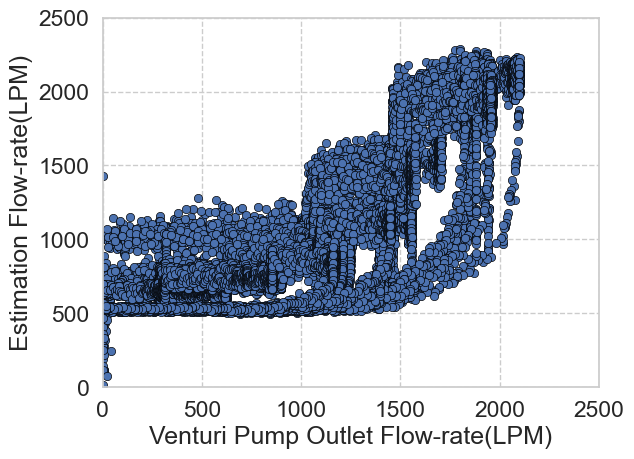

In [21]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Estimation Flow-rate(LPM)')
sns.scatterplot(data=linear_result, x='outlet_flowrate(lpm)', y='estimation_flow(LPM)', edgecolor='black')
plt.xlim(0, 2500)
plt.ylim(0, 2500)
#plt.legend(loc='lower right', ncols=3)

<AxesSubplot:xlabel='Venturi Pump Outlet Flow-rate(LPM)', ylabel='Relative Error(%)'>

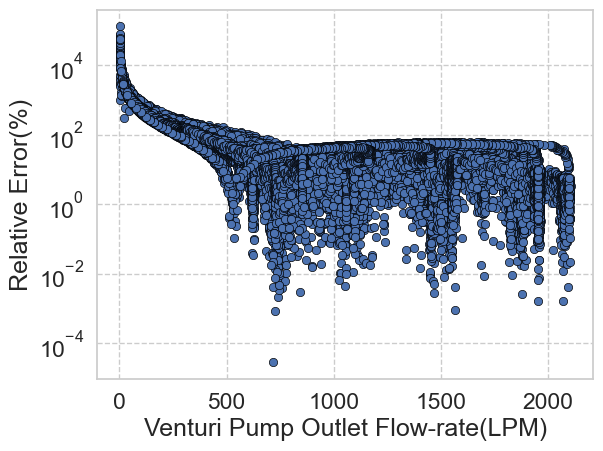

In [22]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Relative Error(%)')
#sns.kdeplot(x=named_val_target, y=relative_error, color='silver')
sns.scatterplot(data=linear_result, x='outlet_flowrate(lpm)', y='relative_error(%)', edgecolor='black')
#plt.legend(loc='upper right', ncol=3)

In [22]:
# create LightGBM model
leaves = 32
lr = 0.001
n_estimators = 5000
boosting_type = 'gbdt'
max_bin = 30

In [23]:
lgb_model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=lr, boosting_type=boosting_type, max_depth=-1, num_leaves=leaves,
                                    force_col_wise=True, verbose=1, n_jobs=-1)

In [24]:
lgb_model.fit(X=train_feature, y=train_target, eval_set=(val_feature, val_target), eval_metric='L2', 
              callbacks=[lgb.early_stopping(stopping_rounds=3000, min_delta=0.01), lgb.log_evaluation(period=100)])

[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 132560, number of used features: 4
[LightGBM] [Info] Start training from score 999.994014
Training until validation scores don't improve for 3000 rounds
[100]	valid_0's l2: 206477
[200]	valid_0's l2: 175261
[300]	valid_0's l2: 149646
[400]	valid_0's l2: 128597
[500]	valid_0's l2: 111298
[600]	valid_0's l2: 97100.1
[700]	valid_0's l2: 85432.1
[800]	valid_0's l2: 75797.6
[900]	valid_0's l2: 67847
[1000]	valid_0's l2: 61196.9
[1100]	valid_0's l2: 55665
[1200]	valid_0's l2: 51089.7
[1300]	valid_0's l2: 47366.8
[1400]	valid_0's l2: 44361.2
[1500]	valid_0's l2: 41886
[1600]	valid_0's l2: 39742.7
[1700]	valid_0's l2: 37916.9
[1800]	valid_0's l2: 36417.2
[1900]	valid_0's l2: 35214.5
[2000]	valid_0's l2: 34206.8
[2100]	valid_0's l2: 33359.2
[2200]	valid_0's l2: 32613.8
[2300]	valid_0's l2: 31878.4
[2400]	valid_0's l2: 31276.6
[2500]	valid_0's l2: 30812.2
[2600]	valid_0's l2: 30417.5
[2700]	valid_0's l2: 3

LGBMRegressor(force_col_wise=True, learning_rate=0.001, n_estimators=5000,
              n_jobs=-1, num_leaves=32, verbose=1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

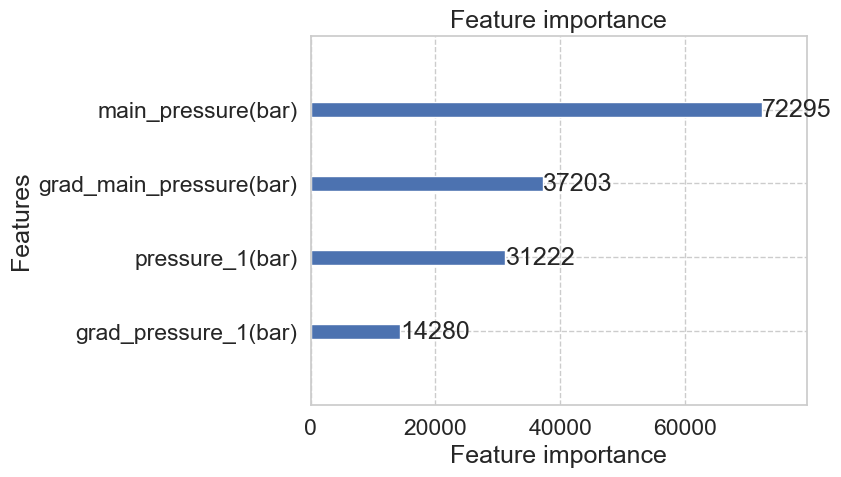

In [25]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
lgb.plot_importance(lgb_model, max_num_features=5)

In [26]:
pred_output = lgb_model.predict(val_feature, num_iteration=lgb_model._best_iteration)
relative_error = abs(val_target.to_numpy()[:, 0] - pred_output)/abs(val_target.to_numpy()[:, 0])*100

lgb_result = pd.DataFrame(['lgb']*len(pred_output), columns=['model_type'])
lgb_result = pd.concat([lgb_result, pd.DataFrame(relative_error, columns=['relative_error(%)'])], axis=1)
lgb_result = pd.concat([lgb_result, pd.DataFrame(pred_output, columns=['estimation_flow(LPM)'])], axis=1)
lgb_result = pd.concat([lgb_result, val_target], axis=1)
lgb_result.reset_index(drop=True, inplace=True)

model_result = pd.concat([model_result, lgb_result], axis=0)

In [27]:
print('The mae of prediction is:', f'{mean_absolute_error(val_target.to_numpy(), pred_output):.1f}')
print('r2 score is :', f'{r2_score(val_target.to_numpy(), pred_output):.3f}')
print('mean relative error:', np.mean(relative_error), end='\n\n')

The mae of prediction is: 112.0
r2 score is : 0.887
mean relative error: 73.93497930117327



In [37]:
index = 0
time_arr = np.arange(0, len(lgb_result))
sns.scatterplot(x=time_arr, y=lgb_result['outlet_flowrate(lpm)'], edgecolor='black')
sns.scatterplot(x=time_arr, y=lgb_result['estimation_flow(LPM)'], edgecolor='black')
plt.xlim(1500, 3500)

NameError: name 'lgb_result' is not defined

In [48]:
seq_len = 30
pred_distance = 0
n_feature = len(feature_col_name_list)
n_output = 1
hidden_size = 500

In [49]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0)
csv_logger = keras.callbacks.CSVLogger('log.csv', append=True, separator=',')
model_chk_point = keras.callbacks.ModelCheckpoint(filepath='lstm_model.keras', monitor="val_loss", verbose=0, save_best_only=True,
                                                  save_weights_only=False, mode="min", save_freq="epoch", initial_value_threshold=None)

In [50]:
def lstm_est_model(): 
    input_layer = keras.layers.Input(shape=(seq_len, n_feature))
    input_flatten_layer = keras.layers.Flatten()(input_layer)
    
    conv_layer = keras.layers.Conv1D(filters=64, kernel_size=7, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(input_layer)
    conv_layer = keras.layers.Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(conv_layer)
    conv_layer = keras.layers.MaxPool1D(pool_size=2)(conv_layer)
    conv_layer = keras.layers.Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(conv_layer)
    conv_layer = keras.layers.Conv1D(filters=64, kernel_size=5, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(conv_layer)
    
    conv_flatten_layer = keras.layers.Flatten()(conv_layer)
    lstm_output_1 = keras.layers.LSTM(units=hidden_size, return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.01), name='lstm_1')(conv_layer)
    
    lstm_output_2 = keras.layers.LSTM(units=hidden_size, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01), name='lstm_2')(conv_layer)
    lstm_output_2 = keras.layers.LSTM(units=int(hidden_size/2), return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.01), name='lstm_3')(lstm_output_2)
    lstm_output = keras.layers.concatenate([input_flatten_layer, conv_flatten_layer, lstm_output_1, lstm_output_2])
    
    output_layer = keras.layers.Dense(n_output, activation='linear')(lstm_output)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])
    
    return model

In [51]:
lstm_model = lstm_est_model()
lstm_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30, 4)]      0           []                               
                                                                                                  
 conv1d_8 (Conv1D)              (None, 24, 64)       1856        ['input_3[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 20, 128)      41088       ['conv1d_8[0][0]']               
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 10, 128)     0           ['conv1d_9[0][0]']               
                                                                                            

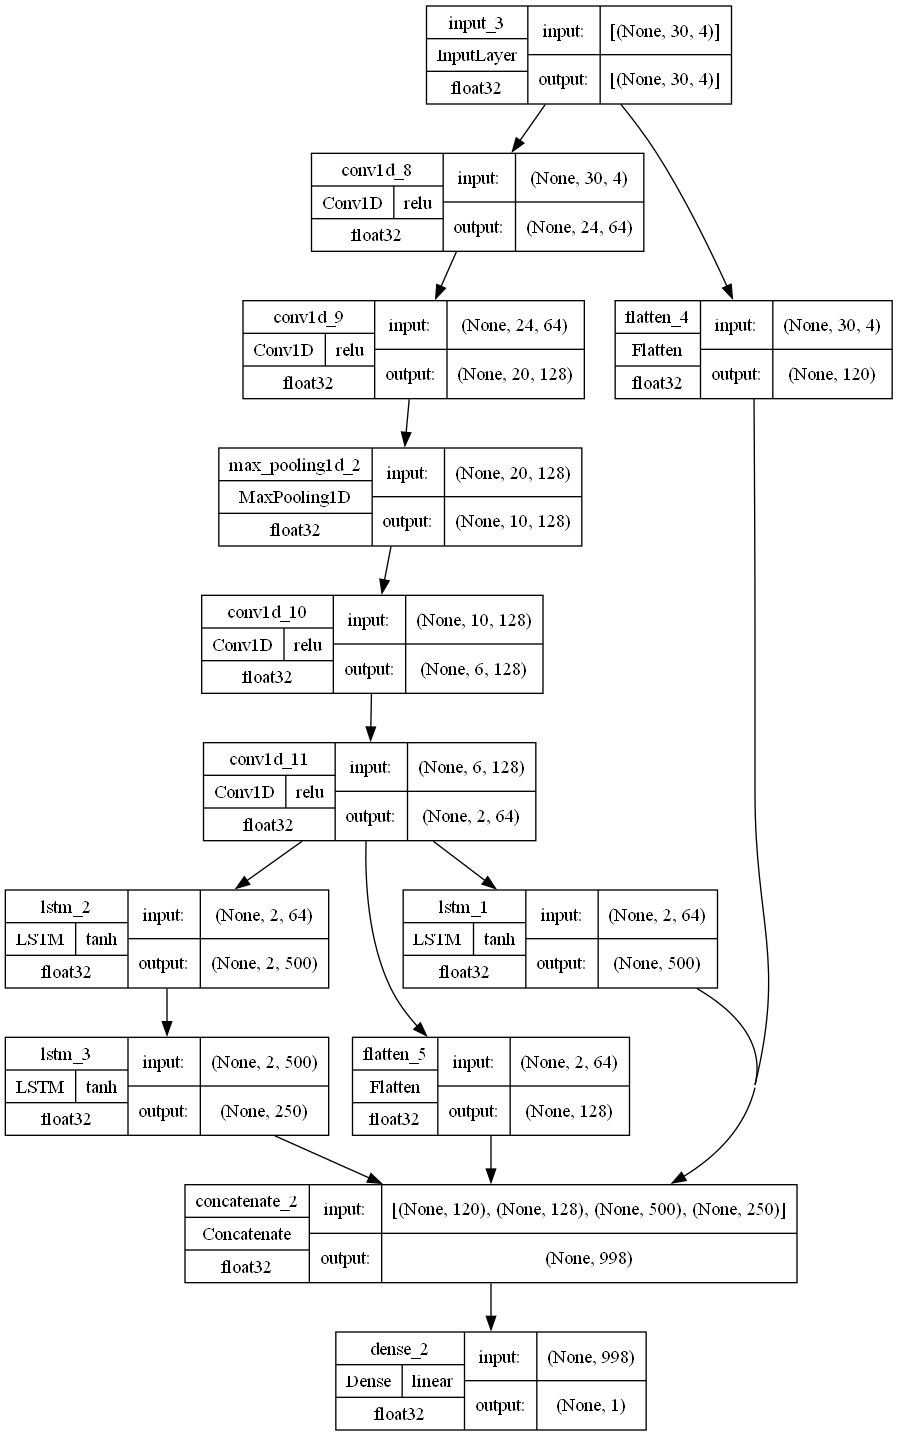

In [52]:
keras.utils.plot_model(lstm_model, to_file='model.png', show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)

In [53]:
model_history = None
metric_log = []
n_epoch = 2000
test_case_list = list(set(dataset['test_case'].astype(np.uint8)))

train_loss_list = []
val_loss_list = []
train_mae_list = []
val_mae_list = []

with tqdm(total = n_epoch * len(test_case_list) * int(train_data['test_case_iter'].max())) as pbar:
    for epoch in range(n_epoch):
        train_loss_list.clear()
        val_loss_list.clear()
        train_mae_list.clear()
        val_mae_list.clear()
        
        for i in test_case_list:
            train_data_sample = train_data[train_data['test_case'] == i]
            val_data_sample = val_data[val_data['test_case'] == i]
 
            for j in range(int(train_data['test_case_iter'].max())):
                train_data_sample_iter = train_data_sample[train_data_sample['test_case_iter'] == j+1]
                train_data_sample_iter_arr = train_data_sample_iter[feature_col_name_list+[target_col_name]].to_numpy()
                train_feature, train_target = create_lstm_dataset(train_data_sample_iter_arr, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=4)
                
                val_data_sample_iter_arr = val_data_sample[feature_col_name_list+[target_col_name]].to_numpy()
                val_feature, val_target = create_lstm_dataset(val_data_sample_iter_arr, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=4)
                
                model_history = lstm_model.fit(x=train_feature, y=train_target, validation_data=(val_feature, val_target), epochs=1, batch_size=10000, verbose=0,
                                               callbacks=[early_stop, csv_logger, model_chk_point])
                pbar.update(1)

                train_loss_list.append(model_history.history['loss'][0])
                val_loss_list.append(model_history.history['val_loss'][0])
                train_mae_list.append(model_history.history['mean_absolute_error'][0])
                val_mae_list.append(model_history.history['val_mean_absolute_error'][0])
                
        train_loss = np.mean(train_loss_list)
        val_loss = np.mean(val_loss_list)
        train_abs_error = np.mean(train_mae_list)
        val_abs_error = np.mean(val_mae_list)
        
        metric_log.append(np.array([epoch, train_loss, val_loss, train_abs_error, val_abs_error]))
        
        print(f'{epoch}, {train_loss:.3f}, {val_loss:.3f}, {train_abs_error:.2f}, {val_abs_error:.2f}')

  0%|          | 0/112000 [00:00<?, ?it/s]

0, 1031134.299, 878232.683, 751.30, 703.02
1, 553707.654, 545354.265, 612.17, 599.89
2, 385692.012, 338684.492, 490.38, 462.54
3, 189863.704, 163010.183, 359.88, 334.43
4, 213188.102, 196643.589, 368.31, 350.79
5, 192941.962, 166367.316, 353.45, 329.87
6, 83872.683, 83812.200, 240.80, 239.16
7, 54107.084, 53444.624, 192.13, 189.51
8, 67374.851, 68064.052, 213.54, 214.51
9, 51130.908, 50582.420, 183.27, 180.13
10, 63695.073, 64634.625, 205.25, 207.62
11, 49126.839, 48767.372, 178.13, 175.00
12, 61775.604, 62900.821, 201.74, 205.08
13, 48025.151, 48025.635, 175.74, 173.61
14, 58795.916, 60079.531, 196.54, 200.30
15, 47428.569, 47936.172, 174.87, 174.77
16, 54975.142, 56241.468, 189.85, 193.39
17, 49155.879, 49908.739, 178.95, 180.24
18, 53402.718, 54346.729, 187.13, 189.65
19, 51969.458, 52574.683, 184.61, 185.78
20, 53662.913, 54255.713, 187.75, 189.20
21, 53929.148, 54242.988, 188.35, 188.83
22, 54624.141, 54902.539, 189.61, 190.18
23, 55379.156, 55363.894, 191.06, 190.70
24, 55666.024

KeyboardInterrupt: 

In [24]:
# train_feature, train_target = create_lstm_dataset(train_data[feature_col_name_list+[target_col_name]].to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=4)
# val_feature, val_target = create_lstm_dataset(val_data[feature_col_name_list+[target_col_name]].to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=4)

In [23]:
# model_history= lstm_model.fit(x=train_feature, y=train_target, validation_data=(val_feature, val_target), epochs=10000, 
#                               batch_size=10000, verbose=0,callbacks=[early_stop, csv_logger, model_chk_point])

In [3]:
best_lstm_model = keras.models.load_model('lstm_model.keras')

In [23]:
train_target_list = []
train_target_pred_list = []

train_data_test_case = train_data['test_case'].astype(np.uint8).unique()

for test_case in tqdm(train_data_test_case):
    train_data_sample = train_data[train_data['test_case'] == test_case]
    
    for i in range(int(train_data['test_case_iter'].max())):
        train_data_sample_iter = train_data_sample[train_data_sample['test_case_iter'] == i+1]
        train_data_sample_iter_arr = train_data_sample_iter[feature_col_name_list+[target_col_name]].to_numpy()
        train_feature, train_target = create_lstm_dataset(train_data_sample_iter_arr, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=4)
        
        train_target_list.append(train_target)
        train_target_pred_list.append(np.squeeze(best_lstm_model.predict(train_feature, verbose=0)))

train_r2_score_list = []
train_mean_abs_error_list = []
train_mean_relative_error_list = []

for i in range(len(train_target_list)):
    train_r2_score_list.append(r2_score(train_target_list[i], train_target_pred_list[i]))
    train_mean_abs_error_list.append(mean_absolute_error(train_target_list[i], train_target_pred_list[i]))
    train_mean_relative_error_list.append(np.mean((abs(train_target_list[i]-train_target_pred_list[i])/train_target_list[i])*100))

print(np.mean(train_r2_score_list), np.mean(train_mean_abs_error_list), np.mean(train_mean_relative_error_list))


  0%|          | 0/28 [00:00<?, ?it/s]

0.9054490941093857 83.34659822869256 17.242880710980135


In [24]:
val_target_list = []
val_target_pred_list = []

val_data_test_case = val_data['test_case'].astype(np.uint8).unique()

for test_case in tqdm(val_data_test_case):
    val_data_sample = val_data[val_data['test_case'] == test_case]
    
    val_data_sample_arr = val_data_sample[feature_col_name_list+[target_col_name]].to_numpy()
    val_feature, val_target = create_lstm_dataset(val_data_sample_arr, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=4)
        
    val_target_list.append(val_target)
    val_target_pred_list.append(np.squeeze(best_lstm_model.predict(val_feature, verbose=0)))

val_r2_score_list = []
val_mean_abs_error_list = []
val_mean_relative_error_list = []

for i in range(len(val_target_list)):
    val_r2_score_list.append(r2_score(val_target_list[i], val_target_pred_list[i]))
    val_mean_abs_error_list.append(mean_absolute_error(val_target_list[i], val_target_pred_list[i]))
    val_mean_relative_error_list.append(np.mean((abs(val_target_list[i]-val_target_pred_list[i])/val_target_list[i])*100))
    
print(np.mean(val_r2_score_list), np.mean(val_mean_abs_error_list), np.mean(val_mean_relative_error_list))

  0%|          | 0/28 [00:00<?, ?it/s]

0.8943872664963639 88.0409989103027 18.636623181348295


<AxesSubplot:>

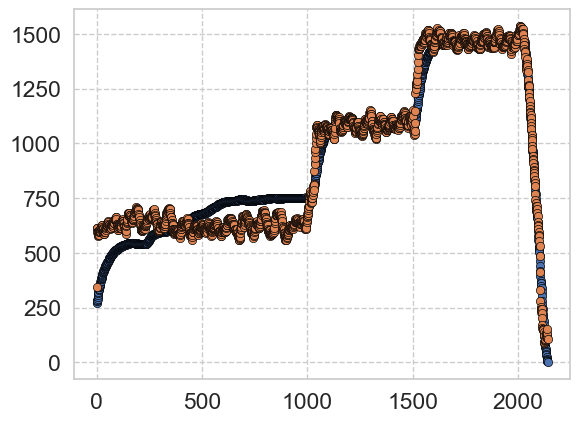

In [25]:
index = 10
time_arr = np.arange(0, len(train_target_list[index]))
sns.scatterplot(x=time_arr, y=train_target_list[index], edgecolor='black')
sns.scatterplot(x=time_arr, y=train_target_pred_list[index], edgecolor='black')

<AxesSubplot:>

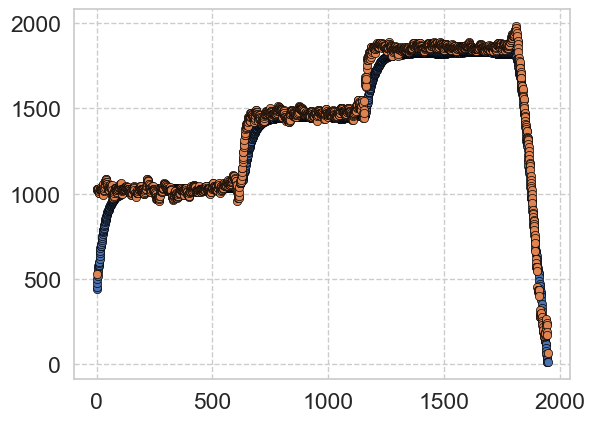

In [36]:
index = 10
time_arr = np.arange(0, len(val_target_list[index]))
sns.scatterplot(x=time_arr, y=val_target_list[index], edgecolor='black')
sns.scatterplot(x=time_arr, y=val_target_pred_list[index], edgecolor='black')

In [44]:
loss_list = model_history.history['loss']
val_loss_list = model_history.history['val_loss']
mean_abs_loss_list = model_history.history['mean_absolute_error']
val_mean_abs_loss_list = model_history.history['val_mean_absolute_error']

<AxesSubplot:xlabel='Epoch', ylabel='loss'>

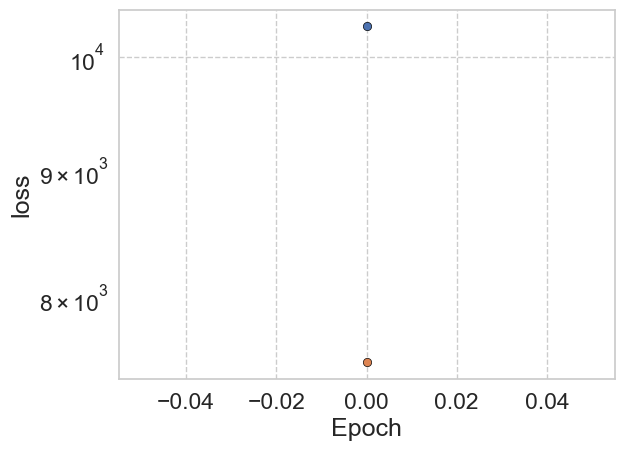

In [45]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('loss')
sns.scatterplot(x=np.arange(0, len(loss_list)), y=loss_list, edgecolor='black')
sns.scatterplot(x=np.arange(0, len(val_loss_list)), y=val_loss_list, edgecolor='black')

(10, 2000)

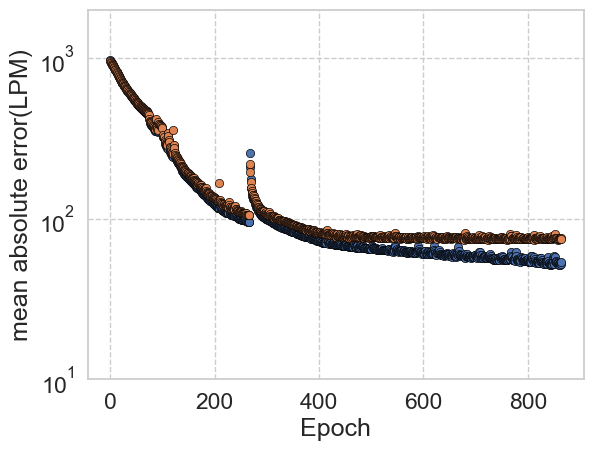

In [54]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.scatterplot(x=np.arange(0, len(mean_abs_loss_list)), y=mean_abs_loss_list, edgecolor='black')
sns.scatterplot(x=np.arange(0, len(val_mean_abs_loss_list)), y=val_mean_abs_loss_list, edgecolor='black')

plt.xlabel('Epoch')
plt.ylabel('mean absolute error(LPM)')
plt.yscale('log')
plt.ylim(10, 2000)

In [122]:
relative_error_list = np.array([])
val_target_arr = np.array([])

for i in range(len(val_target_list)):
    val_target_arr = np.concatenate([val_target_arr, val_target_list[i]])
    relative_error_list = np.concatenate([relative_error_list, np.array(abs(val_target_list[i]-val_target_pred_list[i])/val_target_list[i])*100])

<AxesSubplot:xlabel='Venturi Pump Outlet Flow-rate(LPM)', ylabel='Relative Error(%)'>

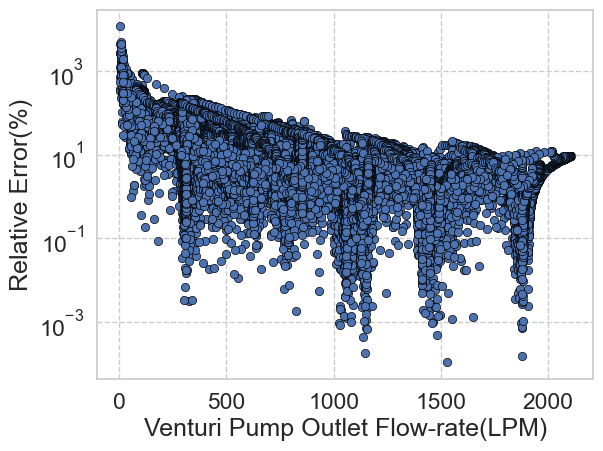

In [78]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Relative Error(%)')
sns.scatterplot(x=val_target_arr, y=relative_error_list, edgecolor='black')

(0.001, 1000)

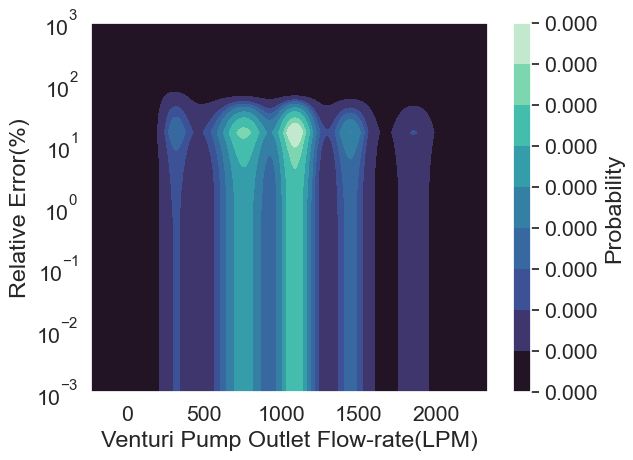

In [125]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')
sns.set(font_scale=1.4)
sns.kdeplot(x=val_target_arr, y=relative_error_list, thresh=0, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability', 'format': '%.3f'})

plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Relative Error(%)')
plt.yscale('log')
plt.ylim(0.001, 1000)

Text(0.5, 0, 'Relative Error(LPM)')

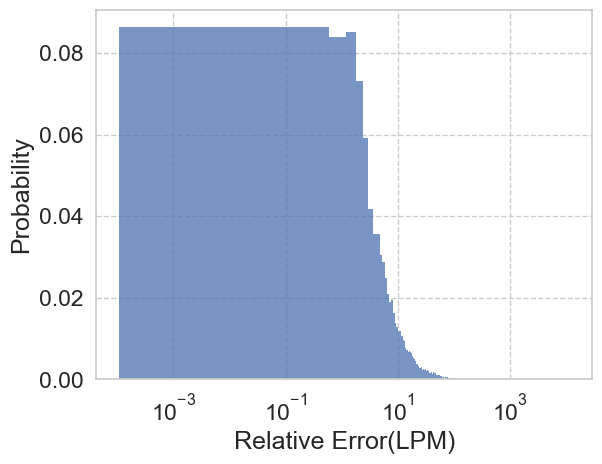

In [113]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
sns.histplot(relative_error_list, stat='probability', common_norm=False)

plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Relative Error(LPM)')

In [114]:
abs_error_list = np.array([])
val_target_arr = np.array([])

for i in range(len(val_target_list)):
    val_target_arr = np.concatenate([val_target_arr, val_target_list[i]])
    abs_error_list = np.concatenate([abs_error_list, np.array(abs(val_target_list[i]-val_target_pred_list[i]))])

<AxesSubplot:xlabel='Venturi Pump Outlet Flow-rate(LPM)', ylabel='Absolute Error(LPM)'>

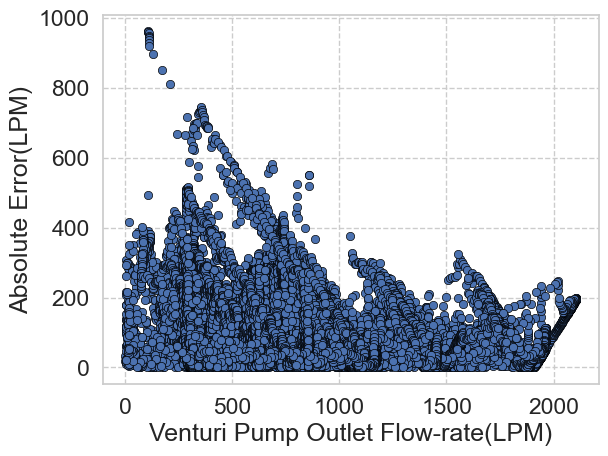

In [115]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Absolute Error(LPM)')
sns.scatterplot(x=val_target_arr, y=abs_error_list, edgecolor='black')

(0.0, 1000.0)

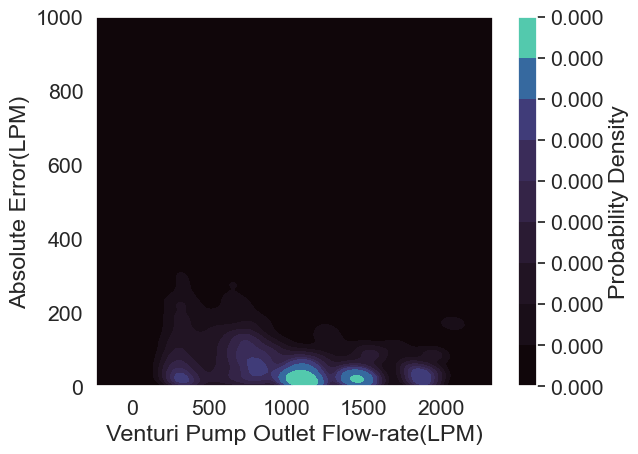

In [126]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')
sns.set(font_scale=1.4)

sns.kdeplot(x=val_target_arr, y=abs_error_list, thresh=0, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.3f'})

plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Absolute Error(LPM)')
plt.ylim(0, 1000)

Text(0.5, 0, 'Absolute Error(LPM)')

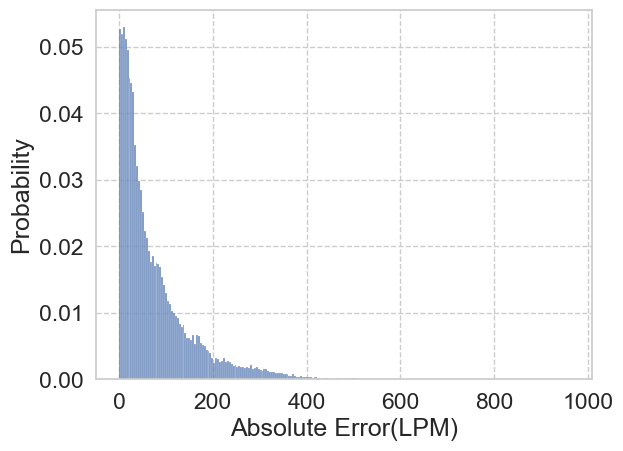

In [117]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
sns.histplot(abs_error_list, stat='probability', common_norm=False)

#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Absolute Error(LPM)')
#plt.legend(loc='upper right', ncol=3

NameError: name 'lgb_result' is not defined

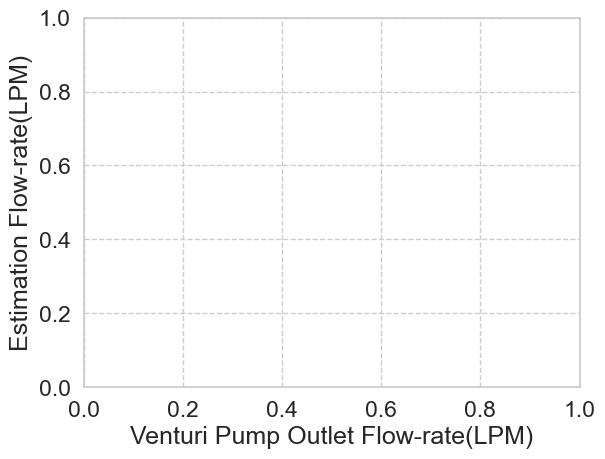

In [23]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Estimation Flow-rate(LPM)')
#sns.kdeplot(x=named_val_target, y=pred_output, color='silver')
sns.scatterplot(data=lgb_result, x='outlet_flowrate(lpm)', y='estimation_flow(LPM)', edgecolor='black')
#plt.legend(loc='lower right', ncol=3)

<AxesSubplot:xlabel='Venturi Pump Outlet Flow-rate(LPM)', ylabel='Relative Error(%)'>

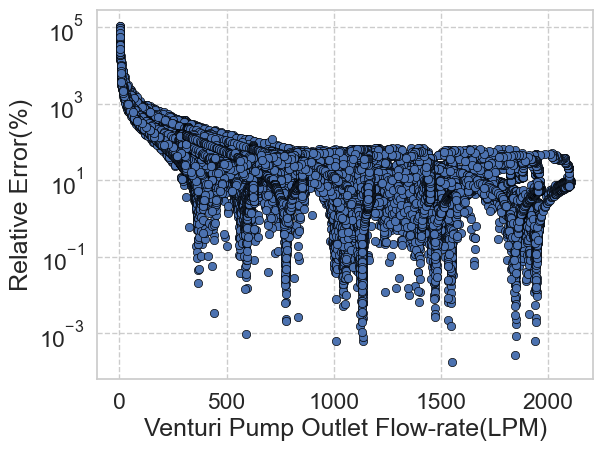

In [29]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Relative Error(%)')
#sns.kdeplot(x=named_val_target, y=relative_error, color='silver')
sns.scatterplot(data=lgb_result, x='outlet_flowrate(lpm)', y='relative_error(%)', edgecolor='black')
#plt.legend(loc='upper right', ncol=3)

KeyboardInterrupt: 

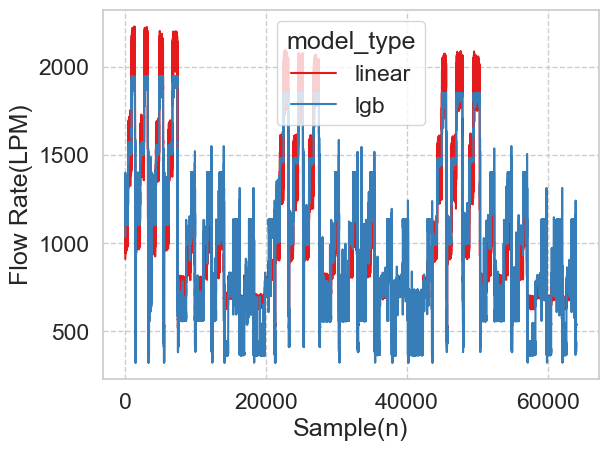

In [30]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.ylabel('Flow Rate(LPM)')
#plt.yscale('log')
plt.xlabel('Sample(n)')
sns.lineplot(data=model_result, x=np.array(model_result.index), y='estimation_flow(LPM)', hue='model_type', palette='Set1')
sns.lineplot(data=model_result, x=np.array(model_result.index), y='outlet_flowrate(lpm)')
plt.xlim(0, 100)

<AxesSubplot:xlabel='Sample(n)', ylabel='Relative Error(%)'>

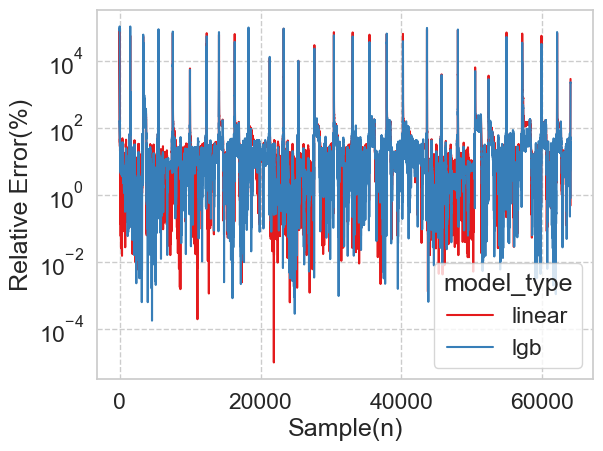

In [31]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.ylabel('Relative Error(%)')
plt.yscale('log')
plt.xlabel('Sample(n)')
sns.lineplot(data=model_result, x=np.array(model_result.index), y='relative_error(%)', hue='model_type', palette='Set1')
#plt.xlim(4000, 4500)
#plt.ylim(0, 100)

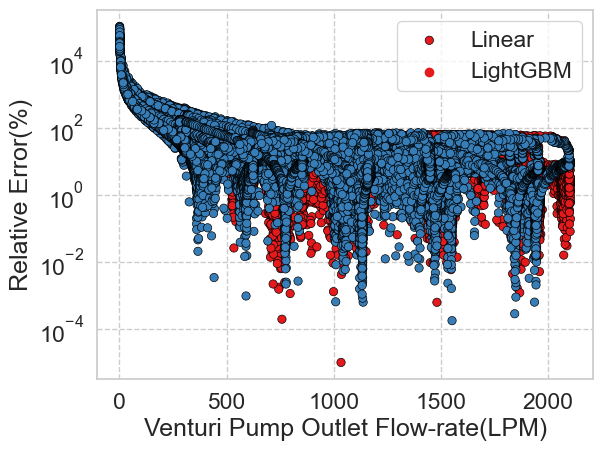

In [32]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Relative Error(%)')
sns.scatterplot(data=model_result, x='outlet_flowrate(lpm)', y='relative_error(%)', hue='model_type', palette='Set1', edgecolor='black')
plt.legend(['Linear', 'LightGBM'])

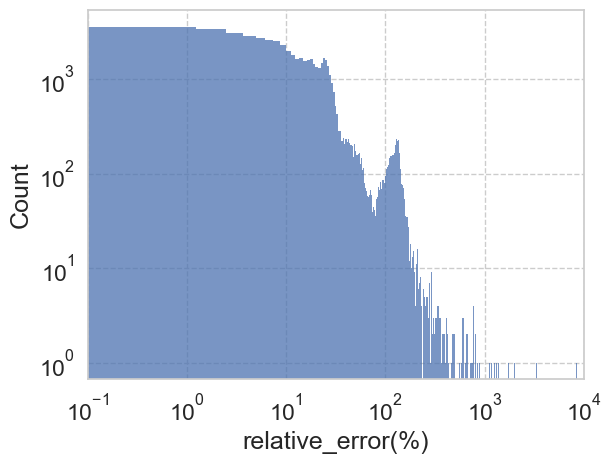

In [57]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(model_result[model_result['model_type']=='linear']['relative_error(%)'])
plt.xlim(0.1, 10000)
plt.yscale('log')
plt.xscale('log')

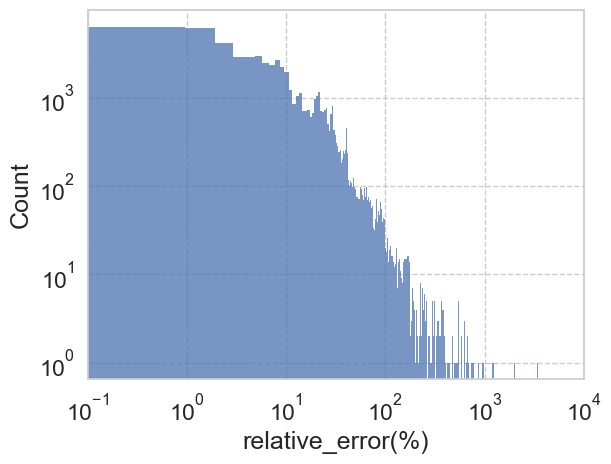

In [58]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(model_result[model_result['model_type']=='lgb']['relative_error(%)'])
plt.xlim(0.1, 10000)
plt.yscale('log')
plt.xscale('log')

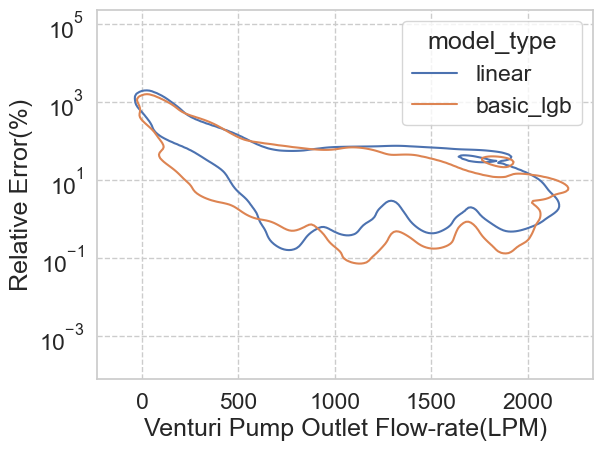

In [82]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Relative Error(%)')
ked_plot = sns.kdeplot(data=model_result, x='outlet_flowrate(lpm)', y='relative_error(%)', hue='model_type', levels=2)

In [88]:
new_lgb_predout = new_lgb_model.predict(new_val_feature)
new_lgb_predout_df = pd.DataFrame(new_lgb_predout, columns=['Estimation_Flow(LPM)'])
new_lgb_rl_error = (np.abs(val_target.to_numpy()-new_lgb_predout)/np.abs(val_target.to_numpy()))*100
new_lgb_rl_error_df = pd.DataFrame(new_lgb_rl_error, columns=['Relative_Error(%)'])
new_lgb_abs_error = np.abs(val_target.to_numpy()-new_lgb_predout)
new_lgb_abs_error_df = pd.DataFrame(new_lgb_abs_error, columns=['Absolute_Error(LPM)'])

print(new_lgb_rl_error_df.mean())
print(new_lgb_abs_error_df.mean())

Relative_Error(%)    83.929067
dtype: float64
Absolute_Error(LPM)    167.862092
dtype: float64


In [89]:
flow_result = pd.concat([named_val_dataset, new_lgb_predout_df, new_lgb_abs_error_df, new_lgb_rl_error_df], axis=1)
flow_result.shape

(9305, 13)

In [90]:
flow_transient = flow_result[flow_result['venturi_pump_outlet_F(LPM)']<750]
flow_transient.reset_index(inplace=True, drop=True)
flow_transient = pd.concat([flow_transient, pd.DataFrame(['transient']*flow_transient.shape[0], columns=['phase_type'])], axis=1)

flow_steady = flow_result[flow_result['venturi_pump_outlet_F(LPM)']>750]
flow_steady.reset_index(inplace=True, drop=True)

flow_steady = pd.concat([flow_steady, pd.DataFrame(['steady']*flow_steady.shape[0], columns=['phase_type'])], axis=1)

flow_phase = pd.concat([flow_transient, flow_steady], axis=0)
flow_phase.reset_index(inplace=True, drop=True)

In [91]:
flow_phase

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
0        12.697                  -1.730                    0.037   
1        12.746                  -2.013                    0.037   
2        12.796                  -1.887                    0.038   
3        12.846                  -1.787                    0.038   
4        12.896                  -1.921                    0.036   
...         ...                     ...                      ...   
9300     67.641                  -1.829                    0.012   
9301     67.691                  -1.893                    0.010   
9302     67.740                  -1.728                    0.005   
9303     67.791                  -2.049                    0.005   
9304     67.840                  -1.629                    0.001   

      venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
0                         0.026                   -2.686   
1                         0.099                   -4.661   
2                         0.181                   -3.734   
3                         0.320                   -4.742   
4                         0.326                   -3.033   
...                         ...                      ...   
9300                      0.470                  180.603   
9301                      0.467                  179.677   
9302                      0.449                  179.361   
9303                      0.443                  179.573   
9304                      0.450                  178.389   

      venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
0                         21.153               750              45   
1                         20.029               750              45   
2                         19.895               750              45   
3                         20.218               750              45   
4                         19.805               750              45   
...                          ...               ...             ...   
9300                     910.229               900              45   
9301                     910.098               900              45   
9302                     910.804               900              45   
9303                     908.185               900              45   
9304                     901.503               900              45   

      suction_height_of_venturi(m)  run_name  Estimation_Flow(LPM)  \
0                            -0.45        31             45.168074   
1                            -0.45        31             46.290761   
2                            -0.45        31             45.168074   
3                            -0.45        31             45.168074   
4                            -0.45        31             45.161081   
...                            ...       ...                   ...   
9300                         -0.45        32            806.066998   
9301                         -0.45        32            806.066998   
9302                         -0.45        32            903.766803   
9303                         -0.45        32            809.998413   
9304                         -0.45        32            898.952836   

      Absolute_Error(LPM)  Relative_Error(%) phase_type  
0               24.015074         113.530347  transient  
1               26.261761         131.118681  transient  
2               25.273074         127.032291  transient  
3               24.950074         123.405254  transient  
4               25.356081         128.028687  transient  
...                   ...                ...        ...  
9300           104.162002          11.443494     steady  
9301           104.031002          11.430747     steady  
9302             7.037197           0.772636     steady  
9303            98.186587          10.811298     steady  
9304             2.550164           0.282879     steady  

[9305 rows x 14 columns]

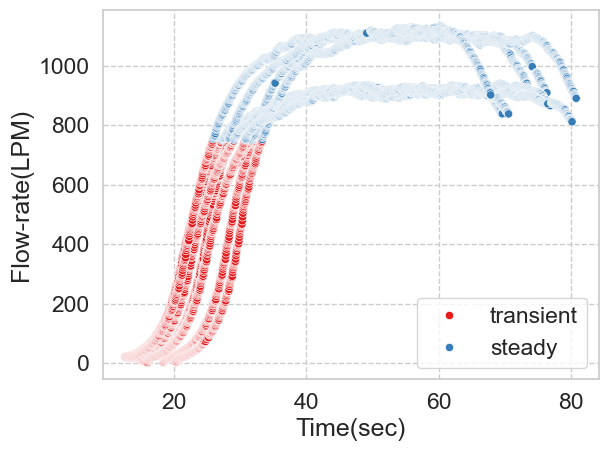

In [92]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Time(sec)')
plt.ylabel('Flow-rate(LPM)')
sns.scatterplot(data=flow_phase, x='time(sec)', y='venturi_pump_outlet_F(LPM)', hue='phase_type', palette='Set1')
plt.legend(loc='lower right')

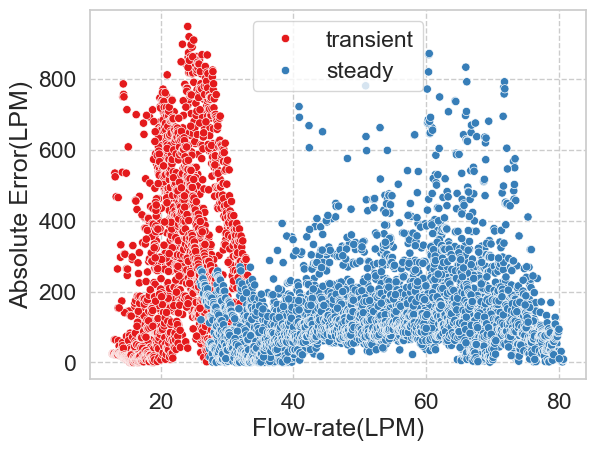

In [93]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Flow-rate(LPM)')
plt.ylabel('Absolute Error(LPM)')
sns.scatterplot(data=flow_phase, x='time(sec)', y='Absolute_Error(LPM)', hue='phase_type', palette='Set1')
plt.legend(loc='upper center')

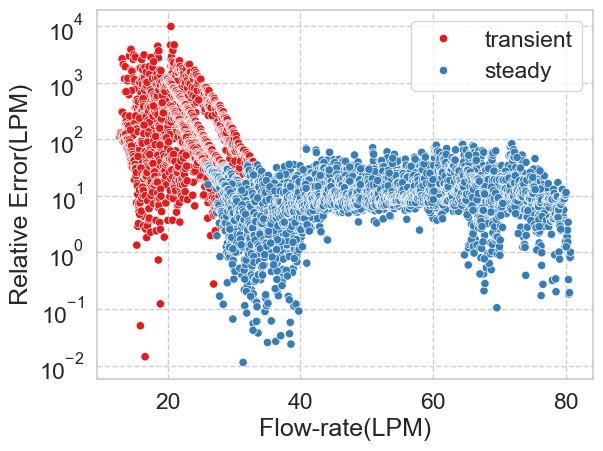

In [94]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Flow-rate(LPM)')
plt.ylabel('Relative Error(LPM)')
sns.scatterplot(data=flow_phase, x='time(sec)',y='Relative_Error(%)', hue='phase_type', palette='Set1')
plt.legend(loc='upper right')

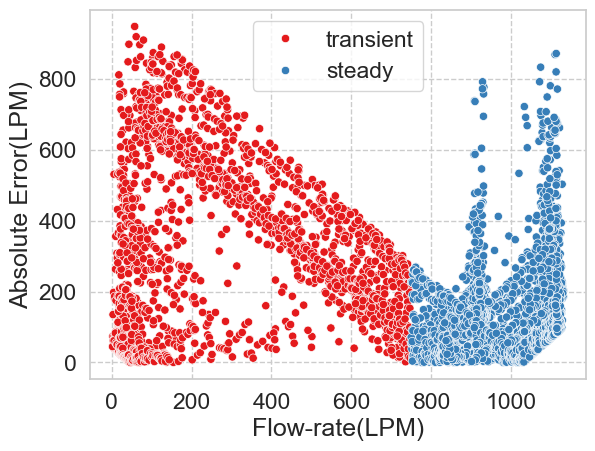

In [95]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Flow-rate(LPM)')
plt.ylabel('Absolute Error(LPM)')
sns.scatterplot(data=flow_phase, x='venturi_pump_outlet_F(LPM)', y='Absolute_Error(LPM)', hue='phase_type', palette='Set1')
plt.legend(loc='upper center')

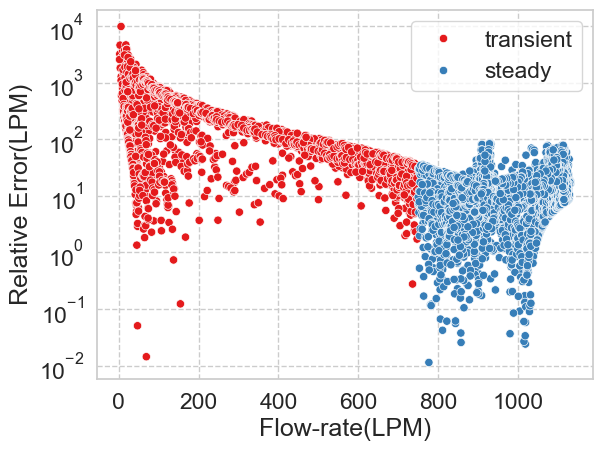

In [96]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Flow-rate(LPM)')
plt.ylabel('Relative Error(LPM)')
sns.scatterplot(data=flow_phase, x='venturi_pump_outlet_F(LPM)',y='Relative_Error(%)', hue='phase_type', palette='Set1')
plt.legend(loc='upper right')

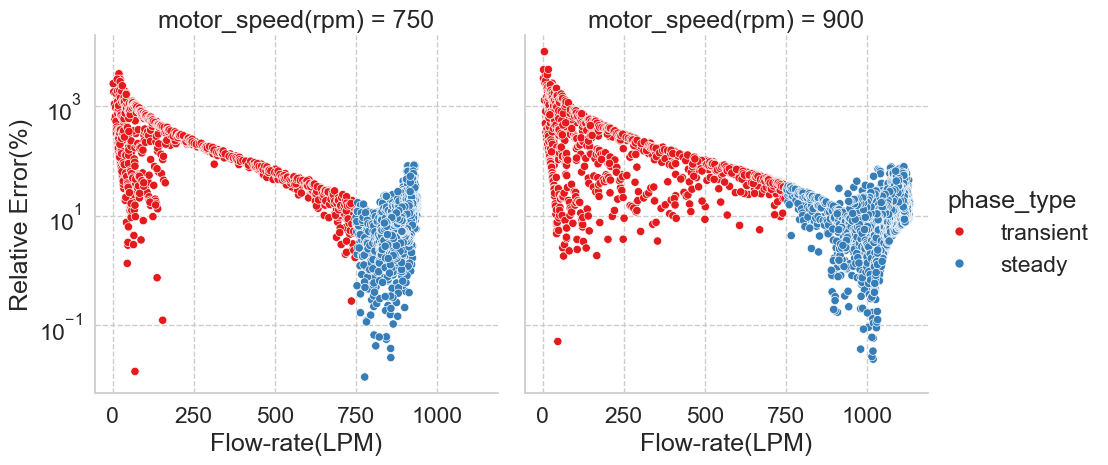

In [97]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
re = sns.relplot(data=flow_phase, x='venturi_pump_outlet_F(LPM)', y='Relative_Error(%)', hue='phase_type', palette='Set1', col='motor_speed(rpm)')
plt.yscale('log')
re.set_ylabels('Relative Error(%)')
re.set_xlabels('Flow-rate(LPM)')

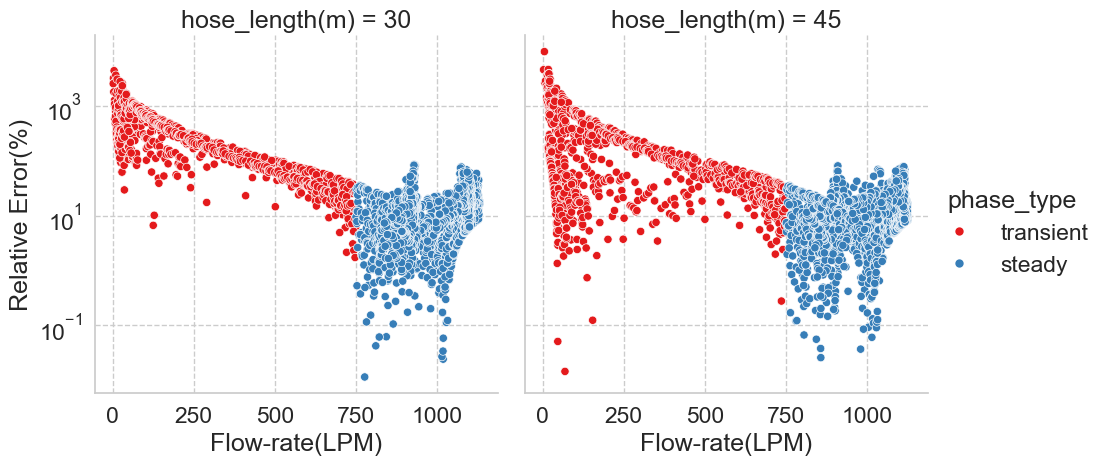

In [98]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
re = sns.relplot(data=flow_phase, x='venturi_pump_outlet_F(LPM)', y='Relative_Error(%)', hue='phase_type', palette='Set1', col='hose_length(m)')
plt.yscale('log')
re.set_ylabels('Relative Error(%)')
re.set_xlabels('Flow-rate(LPM)')

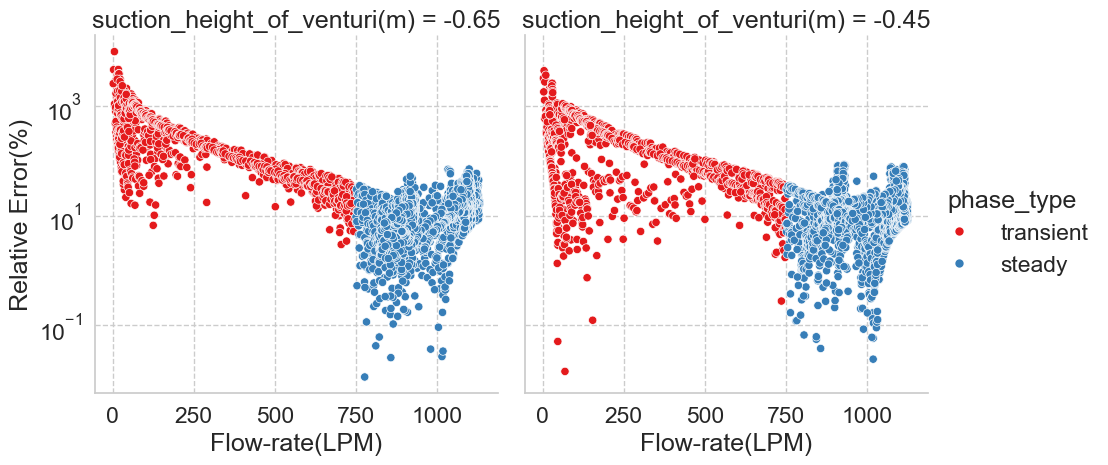

In [99]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
re = sns.relplot(data=flow_phase, x='venturi_pump_outlet_F(LPM)', y='Relative_Error(%)', hue='phase_type', palette='Set1', col='suction_height_of_venturi(m)')
plt.yscale('log')
re.set_ylabels('Relative Error(%)')
re.set_xlabels('Flow-rate(LPM)')

In [100]:
flow_phase.describe()

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count  9305.000000             9305.000000              9305.000000   
mean     45.045720               -1.851021                 0.270931   
std      17.353969                0.096207                 0.095845   
min      12.697000               -2.195000                 0.001000   
25%      30.244000               -1.919000                 0.230000   
50%      44.845000               -1.852000                 0.240000   
75%      59.691000               -1.785000                 0.370000   
max      80.745000               -1.519000                 0.398000   

       venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
count                9305.000000              9305.000000   
mean                    1.545206               157.181888   
std                     0.430442                73.795535   
min                     0.011000                -4.790000   
25%                     1.358000               103.236000   
50%                     1.378000               159.407000   
75%                     2.013000               236.329000   
max                     2.052000               246.386000   

       venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
count                 9305.000000       9305.000000     9305.000000   
mean                   805.678338        823.250940       37.629769   
std                    331.844553         74.983632        7.499280   
min                      1.748000        750.000000       30.000000   
25%                    772.010000        750.000000       30.000000   
50%                    911.693000        750.000000       45.000000   
75%                   1062.772000        900.000000       45.000000   
max                   1131.759000        900.000000       45.000000   

       suction_height_of_venturi(m)     run_name  Estimation_Flow(LPM)  \
count                   9305.000000  9305.000000           9305.000000   
mean                      -0.552504    28.455562            793.956199   
std                        0.099974     2.249053            225.964294   
min                       -0.650000    25.000000             45.161081   
25%                       -0.650000    27.000000            773.099811   
50%                       -0.650000    28.000000            813.430396   
75%                       -0.450000    30.000000            940.747431   
max                       -0.450000    32.000000           1032.447252   

       Absolute_Error(LPM)  Relative_Error(%)  
count          9305.000000        9305.000000  
mean            167.862092          83.929067  
std             160.350315         289.177182  
min               0.009931           0.011427  
25%              73.733271           8.584129  
50%             118.076774          13.544265  
75%             185.365739          25.436897  
max             947.957875        9824.420182

<Axes: xlabel='time(sec)', ylabel='Absolute_Error(LPM)'>

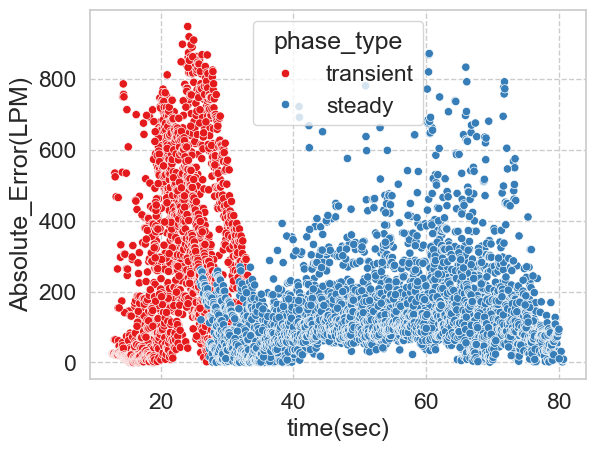

In [101]:
sns.scatterplot(data=flow_phase, x='time(sec)', y='Absolute_Error(LPM)', hue='phase_type', palette='Set1')

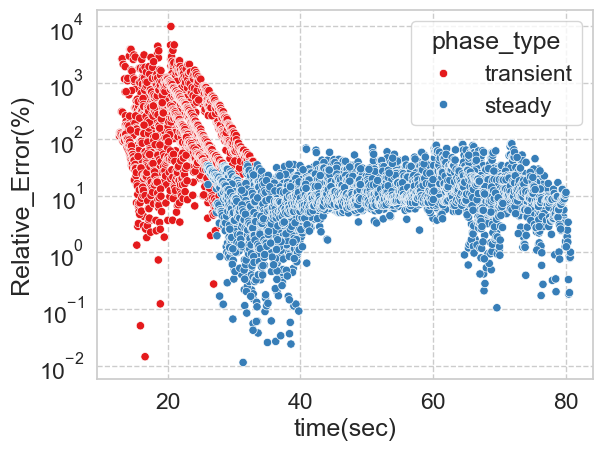

In [102]:
sns.scatterplot(data=flow_phase, x='time(sec)', y='Relative_Error(%)', hue='phase_type', palette='Set1')
plt.yscale('log')

In [103]:
a = flow_phase.copy()
a = a[a['suction_height_of_venturi(m)'] == -0.45]
print(a['Absolute_Error(LPM)'].mean())
print(a['Relative_Error(%)'].mean())
print(a.shape)
print('')

161.82946045146994
67.3501187764551
(4536, 14)


In [104]:
a = flow_phase.copy()
a = a[a['phase_type'] == 'transient']
print(a['Absolute_Error(LPM)'].mean())
print(a['Relative_Error(%)'].mean())
print(a.shape)
print('')

a = flow_phase.copy()
a = a[a['phase_type'] == 'steady']

print(a['Absolute_Error(LPM)'].mean())
print(a['Relative_Error(%)'].mean())
print(a.shape)
print('')

301.4292741572676
307.14641275165536
(2251, 14)

125.23950458963677
12.69824086192822
(7054, 14)


In [105]:
test_vars = ['motor_speed(rpm)', 'hose_length(m)', 'suction_height_of_venturi(m)']
test_var_vals = [700, 900, 30, 50, -0.65, -0.45]

a = flow_phase.copy()
a = a[a['motor_speed(rpm)'] == 750]
a = a[a['phase_type'] == 'steady']

print(a['Absolute_Error(LPM)'].mean())
print(a['Relative_Error(%)'].mean())

107.28728417974591
11.861380096374589


In [107]:
# save model
joblib.dump(linear_model, 'saved_model'+os.sep+'linear_model'+'.pkl')
print('linear model is saved!')

joblib.dump(basic_lgb_model, 'saved_model' + os.sep + 'basic_lgb_model' + '.pkl')
print('lgb model is saved!')

joblib.dump(new_lgb_model, 'saved_model' + os.sep + 'new_model' + '.pkl')
print('new lgb model is saved!')


linear model is saved!
lgb model is saved!
new lgb model is saved!


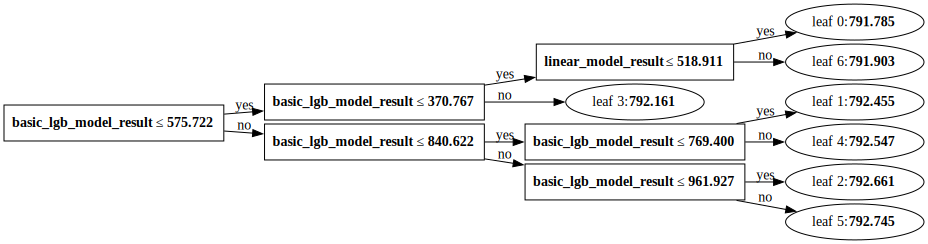

In [108]:
lgb.create_tree_digraph(new_lgb_model)